In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from skimage.transform import resize, rotate
%matplotlib inline

In [ ]:
im = cv2.imread("data/0.png")
plt.imshow(im)

In [2]:
def bounding(img):
    assert img.shape[2] == 4
    h, w = img.shape[:2]
    top, bot, left, right = 0, h, 0, w
    for i in range(h):
        for j in range(w):
            if img[i,j, -1] > 50 and top == 0:
                top = i
            if img[h-i-1, j, -1] > 50 and bot == h:
                bot = h-i-1
            if top != 0 and bot != h:
                break
                
    for j in range(w):
            for i in range(h):
                if img[i,j, -1] > 50 and left == 0:
                    left  = j
                if img[i, w - j - 1, -1] > 50 and right == w:
                    right = w - j - 1
                if left != 0 and right != w:
                    break
                    
    return top, bot, left, right

In [26]:
def resize_objects(size):
    objects = os.listdir('objects/')
    for obj in objects:
        if '_' in obj:
            continue
        obj_im = imread("objects/" + obj)
        top, bot, left, right = bounding(obj_im)
        scale = size / (bot - top)
        obj_im = resize(obj_im[top:bot, left:right,:], (size, int((-left + right)*scale))) * 255
        obj_img = Image.fromarray(obj_im.astype(np.uint8))
        obj_img.load() # required for png.split()

        background = Image.new("RGB", obj_img.size, (0, 0, 0))
        background.paste(obj_img, mask=obj_img.split()[3]) # 3 is the alpha channel

        background.save('objects/{}_{}.jpg'.format(size, obj.split('.')[0]), 'JPEG', quality=100)

In [28]:
resize_objects(64)
# resize_objects(32)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


145 68 144


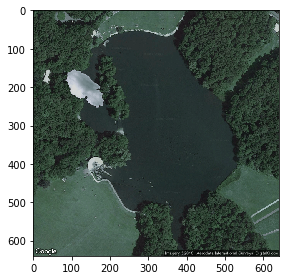

In [34]:
im = cv2.imread("train_data/0.png")
angle = np.random.choice(range(181))
obj = imread('objects/64_1.jpg')
obj = rotate(obj, angle, resize=True, clip=False, cval= 0.,preserve_range= True).astype(np.uint8) 
pos_x = np.random.choice(range(im.shape[1] - obj.shape[1]))
pos_y = np.random.choice(range(im.shape[0] - obj.shape[0]))
print(angle, pos_x, pos_y)
roi = im[pos_y:pos_y+obj.shape[0], pos_x:pos_x+obj.shape[1]]
img2gray = cv2.cvtColor(obj,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

im_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
obj_fg = cv2.bitwise_and(obj,obj,mask = mask)
dst = cv2.add(im_bg, obj_fg)
im[pos_y:pos_y+obj.shape[0], pos_x:pos_x+obj.shape[1]] = dst
imshow(im)

In [2]:
test_ims = os.listdir("test_data")
for idx in test_ims:
    im = cv2.imread("test_data/" + idx)
    size = np.random.choice([32, 64, 128])
    obj_id = np.random.choice(range(16))
    angle = np.random.choice(range(30))
    obj = imread('objects/{}_{}.jpg'.format(size, obj_id))
    obj = rotate(obj, angle, resize=True, clip=False, cval= 0.,preserve_range= True).astype(np.uint8) 
    pos_x = np.random.choice(range(im.shape[1] - obj.shape[1]))
    pos_y = np.random.choice(range(im.shape[0] - obj.shape[0]))
    roi = im[pos_y:pos_y+obj.shape[0], pos_x:pos_x+obj.shape[1]]
    img2gray = cv2.cvtColor(obj,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    im_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    obj_fg = cv2.bitwise_and(obj,obj,mask = mask)
    dst = cv2.add(im_bg, obj_fg)
    im[pos_y:pos_y+obj.shape[0], pos_x:pos_x+obj.shape[1]] = dst
#     imshow(im)
    cv2.imwrite("test_data/forged_{}_{}_{}_{}_{}.png".format(idx.split('.')[0], size, pos_x, pos_y, obj_id), im)

In [3]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [9]:
images = os.listdir("test_data/")
for i in images:
    im = cv2.imread("test_data/" + i)
    size, pos_x, pos_y = 0, 0, 0
    counter = 0
    if "forged" in i:
        pos_x, pos_y = map(lambda x: int(x), i.split('_')[3:5])
        size = int(i.split('_')[2])
    for (x, y, patch) in sliding_window(im, 32, (64, 64)):
        if patch.shape[0] < 64 or patch.shape[1] < 64:
            continue
        if (pos_x !=0 or pos_y !=0) and x >= pos_x - size*0.5 and x < pos_x + size*0.5 and y >= pos_y - size*0.5 and y < pos_y + size*0.5:
            cv2.imwrite("forged_patches/{}_{}.png".format(i.split('.')[0], counter), patch)
        else:
            cv2.imwrite("pristine_patches/{}_{}.png".format(i.split('.')[0], counter), patch)
        counter +=1

In [ ]:
images = os.listdir("test_patches/")
counter = 0
for i in images:
    im = cv2.imread("test_patches/" + i)
    if im.shape != (64,64,3):
        os.remove("test_patches/" + i)
        counter +=1

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from adversarial_autoencoder import *
aae = AdversarialAutoencoder()
aae.adversarial_autoencoder.load_weights("adversarial_ae.h5")

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2416      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1040      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
__________

In [13]:
import os
import cv2
test_imgs = os.listdir("pristine_patches")
pristines = []
stage = len(test_imgs) // 100
cur_stage = 0
for i, idx in enumerate(test_imgs):
    if (i+1) % 100 == 0:
        cur_stage +=1
        
    print("[" + "="*cur_stage + " "*(stage - cur_stage) + "]", end='\r', flush= True)
    im = cv2.imread("pristine_patches/" + idx)
    im = im.astype(np.float32)/255.0
    encoding = aae.adversarial_autoencoder.layers[1].predict(np.expand_dims(im, 0))
    encoding = encoding.reshape(2048, 1)
    pristines.append(encoding)

In [15]:
test_imgs = os.listdir("forged_patches")
forged = []
stage = len(test_imgs) // 100
cur_stage = 0
for i, idx in enumerate(test_imgs):
    if (i+1) % 100 == 0:
        cur_stage +=1
        
    print("[" + "="*cur_stage + " "*(stage - cur_stage) + "]", end='\r', flush= True)
    im = cv2.imread("forged_patches/" + idx)
    im = im.astype(np.float32)/255.0
    encoding = aae.adversarial_autoencoder.layers[1].predict(np.expand_dims(im, 0))
    encoding = encoding.reshape(2048, 1)
    forged.append(encoding)

In [17]:
pca = PCA(n_components=3)
pca.fit(pristines)
p_3d = pca.transform(pristines)
pca.fit(forged)
f_3d = pca.transform(forged)

MemoryError: 

In [14]:
pristines = np.squeeze(np.asarray(pristines))
pristines.shape

(34656, 2048)

In [16]:
forged = np.squeeze(np.asarray(forged))
forged.shape

(34656, 2048)

In [ ]:
np.save("pristines", pristines)
np.save("forged", forged)

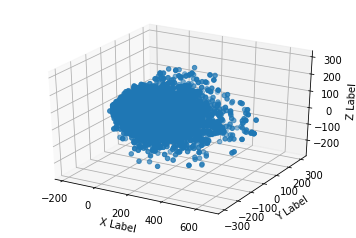

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [11]:
import os
names = os.listdir("test_patches/")
for n in names:
    if "forged" in  n:
        os.rename("test_patches/" +n, "forged_patches/"+ n)